<a href="https://colab.research.google.com/github/jimmymanianchira/FastAi_2019_part2/blob/master/FASTAI_Lesson9_p1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##  This is based on Initializing Notebook which covers on importance of activation

In [0]:
import torch
import math

In [0]:

x = torch.randn(512)
a = torch.randn(512,512)

In [5]:

for i in range(100): x = a @ x
x.mean(),x.std()

(tensor(nan), tensor(nan))

In [8]:
# Trying with initalization of 0.01
x = torch.randn(512)
a = torch.randn(512,512) * 0.01
for i in range(100): x=a@x
x.mean(),x.std()

(tensor(0.), tensor(0.))

In [15]:
x = torch.randn(512)
a = torch.randn(512,512) /(math.sqrt(512))
for i in range(100): x=a@x
x.mean(),x.std()

(tensor(0.2835), tensor(11.2081))

In [16]:
x = torch.randn(512)
a = torch.randn(512,512) /(math.sqrt(512))
for i in range(100): x=a@x
x.mean(),x.std()

(tensor(-0.0864), tensor(2.0447))

In [17]:

mean,sqr = 0.,0.
for i in range(100):
    x = torch.randn(512)
    a = torch.randn(512, 512) * math.sqrt(2/512)
    y = a @ x
    y = y.clamp(min=0)
    mean += y.mean().item()
    sqr  += y.pow(2).mean().item()
mean/100,sqr/100

(0.5626889711618424, 0.9960777461528778)

## Now going to Mini_batch_training notebook

In [131]:
  !curl -s https://course.fast.ai/setup/colab | bash
  !git clone https://github.com/fastai/course-v3.git
  %cd course-v3
  %cd nbs/dl2

Updating fastai...
Done.
Cloning into 'course-v3'...
remote: Enumerating objects: 37, done.
remote: Counting objects: 100% (37/37), done.
remote: Compressing objects: 100% (33/33), done.
remote: Total 4952 (delta 11), reused 14 (delta 2), pack-reused 4915
Receiving objects: 100% (4952/4952), 233.54 MiB | 36.47 MiB/s, done.
Resolving deltas: 100% (2662/2662), done.
/content/course-v3/nbs/dl2/course-v3
/content/course-v3/nbs/dl2/course-v3/nbs/dl2


In [0]:
%reload_ext autoreload
%autoreload 2

%matplotlib inline
import matplotlib

In [0]:

from exp.nb_02 import *
import torch.nn.functional as F
mpl.rcParams['image.cmap'] = 'gray'
x_train,y_train,x_valid,y_valid = get_data()

n,m = x_train.shape
c = y_train.max()+1
nh = 50

In [134]:
c

tensor(10)

In [0]:
class Model(nn.Module):
    def __init__(self, n_in, nh, n_out):
        super().__init__()
        self.layers = [nn.Linear(n_in,nh), nn.ReLU(), nn.Linear(nh,n_out)]
        
    def __call__(self, x):
        for l in self.layers: x = l(x)
        return x



In [0]:
model=Model(m,nh,10)

In [0]:

pred = model(x_train)

In [0]:
b=pred.exp().sum()
c=pred.exp().sum(-1,keepdim=True)

In [139]:
b

tensor(497444.4688, grad_fn=<SumBackward0>)

In [140]:
c.shape

torch.Size([50000, 1])

In [141]:
c

tensor([[10.1104],
        [ 9.9340],
        [ 9.8967],
        ...,
        [10.0139],
        [ 9.8169],
        [10.1291]], grad_fn=<SumBackward2>)

In [0]:
def log_softmax(x): return (x.exp()/(x.exp().sum(-1,keepdim=True))).log()

In [0]:

sm_pred = log_softmax(pred)

In [144]:
sm_pred[0:3]

tensor([[-2.4789, -2.1008, -2.2049, -2.2178, -2.2570, -2.3966, -2.0266, -2.4231,
         -2.6429, -2.4372],
        [-2.4938, -2.2023, -2.1472, -2.1734, -2.2542, -2.3722, -2.0786, -2.4297,
         -2.5613, -2.4343],
        [-2.4915, -2.1550, -2.1151, -2.2345, -2.2424, -2.3634, -2.2092, -2.3814,
         -2.5405, -2.3829]], grad_fn=<SliceBackward>)

In [145]:
y_train[0:3]

tensor([5, 0, 4])

In [0]:

def nll(input, target): return -input[range(target.shape[0]), target].mean()

In [147]:
-sm_pred[0][range(y_train[0:1].shape[0],y_train[0:1])]

tensor([2.1008, 2.2049, 2.2178, 2.2570], grad_fn=<NegBackward>)

In [148]:
sm_pred[0:1][range(y_train[0:1].shape[0]),y_train[0:1]]

tensor([-2.3966], grad_fn=<IndexBackward>)

In [0]:
loss = nll(sm_pred, y_train)

In [150]:
loss

tensor(2.3179, grad_fn=<NegBackward>)

In [0]:

def log_softmax(x): return x - x.exp().sum(-1,keepdim=True).log()

In [0]:
def logsumexp(x):
    m = x.max(-1)[0]
    return m + (x-m[:,None]).exp().sum(-1).log()

In [0]:
def log_softmax(x): return x - x.logsumexp(-1,keepdim=True)

In [0]:
test_near(F.nll_loss(F.log_softmax(pred, -1), y_train), loss)

In [0]:
loss_func=F.cross_entropy
def accuracy(out,yb): return (torch.argmax(out,dim=1)==yb).float().mean()

In [156]:
bs=64                  

xb = x_train[0:bs]   
preds = model(xb)      
preds[0], preds.shape


(tensor([-0.1653,  0.2128,  0.1087,  0.0957,  0.0566, -0.0830,  0.2870, -0.1095,
         -0.3293, -0.1236], grad_fn=<SelectBackward>), torch.Size([64, 10]))

In [0]:
y_b=y_train[0:bs]

In [158]:
accuracy(preds,y_b)

tensor(0.0312)

In [159]:
loss_func(preds,y_b)

tensor(2.3091, grad_fn=<NllLossBackward>)

In [160]:
n

50000

In [0]:

lr = 0.5   # learning rate
epochs = 1 # how many epochs to train for

for epoch in range(epochs):
    for i in range((n-1)//bs + 1):
#         set_trace()
        start_i = i*bs
        end_i = start_i+bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        loss = loss_func(model(xb), yb)

        loss.backward()
        with torch.no_grad():
            for l in model.layers:
                if hasattr(l, 'weight'):
                    l.weight -= l.weight.grad * lr
                    l.bias   -= l.bias.grad   * lr
                    l.weight.grad.zero_()
                    l.bias  .grad.zero_()

In [162]:
loss_func(model(xb), yb), accuracy(model(xb), yb)


(tensor(0.1205, grad_fn=<NllLossBackward>), tensor(0.9375))

In [163]:
model

Model()

In [0]:
class Model(nn.Module):
    def __init__(self, n_in, nh, n_out):
        super().__init__()
        self.l1 = nn.Linear(n_in,nh)
        self.l2 = nn.Linear(nh,n_out)
        
    def __call__(self, x): return self.l2(F.relu(self.l1(x)))

In [0]:
model = Model(m, nh, 10)

In [166]:
model

Model(
  (l1): Linear(in_features=784, out_features=50, bias=True)
  (l2): Linear(in_features=50, out_features=10, bias=True)
)

In [0]:
layers = [nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,10)]

In [0]:
class Model(nn.Module):
  def __init__(self,layers):
    super().__init__()
    self.layers=layers
    for i,l in enumerate(self.layers): self.add_module(f'layer_{i}', l)
      
  def __call__(x):
    for l in self.layers: x=l(x)
    return (x)

In [169]:
model=Model(layers)
model

Model(
  (layer_0): Linear(in_features=784, out_features=50, bias=True)
  (layer_1): ReLU()
  (layer_2): Linear(in_features=50, out_features=10, bias=True)
)

In [0]:

class SequentialModel(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.layers = nn.ModuleList(layers)
        
    def __call__(self, x):
        for l in self.layers: x = l(x)
        return x

    

In [0]:
model=SequentialModel(layers)

In [0]:
def fit():
    for epoch in range(epochs):
        for i in range((n-1)//bs + 1):
            start_i = i*bs
            end_i = start_i+bs
            xb = x_train[start_i:end_i]
            yb = y_train[start_i:end_i]
            loss = loss_func(model(xb), yb)

            loss.backward()
            with torch.no_grad():
                for p in model.parameters(): p -= p.grad * lr
                model.zero_grad()

In [173]:

fit()
loss_func(model(xb), yb), accuracy(model(xb), yb)

(tensor(0.2429, grad_fn=<NllLossBackward>), tensor(0.9375))

In [0]:
class Optimizer():
    def __init__(self, params, lr=0.5): self.params,self.lr=list(params),lr
        
    def step(self):
        with torch.no_grad():
            for p in self.params: p -= p.grad * lr

    def zero_grad(self):
        for p in self.params: p.grad.data.zero_()

In [0]:
model = nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,10))

In [0]:
opt = Optimizer(model.parameters())

In [0]:
for epoch in range(epochs):
    for i in range((n-1)//bs + 1):
        start_i = i*bs
        end_i = start_i+bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

In [178]:

loss,acc = loss_func(model(xb), yb), accuracy(model(xb), yb)
loss,acc

(tensor(0.2232, grad_fn=<NllLossBackward>), tensor(0.9375))

In [0]:
#export
from torch import optim

In [0]:
optim.SGD.step??

In [0]:
optim.Adam??

In [0]:
def get_model():
    model = nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,10))
    return model, optim.SGD(model.parameters(), lr=lr)

In [183]:
model,opt = get_model()
loss_func(model(xb), yb)

tensor(2.3372, grad_fn=<NllLossBackward>)

In [0]:

for epoch in range(epochs):
    for i in range((n-1)//bs + 1):
        start_i = i*bs
        end_i = start_i+bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

In [185]:
loss,acc = loss_func(model(xb), yb), accuracy(model(xb), yb)
loss,acc

(tensor(0.0987, grad_fn=<NllLossBackward>), tensor(0.9375))

In [0]:
optim.Adam??

In [0]:
def get_model():
    model = nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,10))
    return model, optim.Adam(model.parameters())

In [188]:
model,opt = get_model()
loss_func(model(xb), yb)


tensor(2.3685, grad_fn=<NllLossBackward>)

In [0]:

for epoch in range(epochs):
    for i in range((n-1)//bs + 1):
        start_i = i*bs
        end_i = start_i+bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

In [190]:
loss,acc = loss_func(model(xb), yb), accuracy(model(xb), yb)
loss,acc

(tensor(0.5070, grad_fn=<NllLossBackward>), tensor(0.8750))

In [0]:

class Dataset():
    def __init__(self, x, y): self.x,self.y = x,y
    def __len__(self): return len(self.x)
    def __getitem__(self, i): return self.x[i],self.y[i]
    

train_ds,valid_ds = Dataset(x_train, y_train),Dataset(x_valid, y_valid)

In [203]:
xb,yb = train_ds[0:5]
type(xb),type(yb)

(torch.Tensor, torch.Tensor)

In [0]:
class DataLoader():
    def __init__(self, ds, bs): self.ds,self.bs = ds,bs
    def __iter__(self):
        for i in range(0, len(self.ds), self.bs): yield self.ds[i:i+self.bs]

In [0]:

train_dl = DataLoader(train_ds, bs)
valid_dl = DataLoader(valid_ds, bs)

In [0]:

xb,yb = next(iter(valid_dl))

In [0]:

model,opt = get_model()

def fit():
    for epoch in range(epochs):
        for xb,yb in train_dl:
            pred = model(xb)
            loss = loss_func(pred, yb)
            loss.backward()
            opt.step()
            opt.zero_grad()

In [0]:
fit()

In [0]:
loss,acc = loss_func(model(xb), yb), accuracy(model(xb), yb)

In [210]:
loss,acc

(tensor(0.2751, grad_fn=<NllLossBackward>), tensor(0.9375))

In [213]:
torch.randperm(15)

tensor([ 7,  2,  6, 10,  9, 12,  5,  8,  3,  0, 11,  4, 14,  1, 13])

In [215]:
torch.arange(15)

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])

In [0]:
import numpy as np

In [217]:
np.arange(15)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])

In [0]:
class Sampler():
    def __init__(self, ds, bs, shuffle=False):
        self.n,self.bs,self.shuffle = len(ds),bs,shuffle
        
    def __iter__(self):
        self.idxs = torch.randperm(self.n) if self.shuffle else torch.arange(self.n)
        for i in range(0, self.n, self.bs): yield self.idxs[i:i+self.bs]

In [0]:
small_ds = Dataset(*train_ds[:10])

In [221]:

s = Sampler(small_ds,3,False)
[o for o in s]

[tensor([0, 1, 2]), tensor([3, 4, 5]), tensor([6, 7, 8]), tensor([9])]

In [222]:
s = Sampler(small_ds,3,True)
[o for o in s]

[tensor([2, 1, 4]), tensor([6, 9, 5]), tensor([3, 8, 0]), tensor([7])]

In [0]:
def collate(b):
    xs,ys = zip(*b)
    return torch.stack(xs),torch.stack(ys)

class DataLoader():
    def __init__(self, ds, sampler, collate_fn=collate):
        self.ds,self.sampler,self.collate_fn = ds,sampler,collate_fn
        
    def __iter__(self):
        for s in self.sampler: yield self.collate_fn([self.ds[i] for i in s])

In [0]:
train_samp = Sampler(train_ds, bs, shuffle=True)
valid_samp = Sampler(valid_ds, bs, shuffle=False)

In [0]:
train_dl = DataLoader(train_ds, sampler=train_samp, collate_fn=collate)
valid_dl = DataLoader(valid_ds, sampler=valid_samp, collate_fn=collate)


tensor(8)

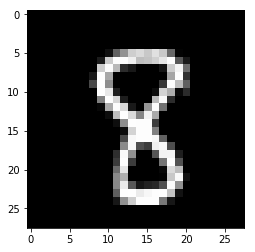

In [240]:
xb,yb = next(iter(valid_dl))
plt.imshow(xb[1].view(28,28))
yb[1]

In [241]:
model,opt = get_model()
fit()

loss,acc = loss_func(model(xb), yb), accuracy(model(xb), yb)
assert acc>0.7
loss,acc

(tensor(0.3104, grad_fn=<NllLossBackward>), tensor(0.9219))

In [0]:
from torch.utils.data import DataLoader, SequentialSampler, RandomSampler

In [0]:
SequentialSampler??

In [0]:
train_dl = DataLoader(train_ds, bs, sampler=RandomSampler(train_ds), collate_fn=collate)
valid_dl = DataLoader(valid_ds, bs, sampler=SequentialSampler(valid_ds), collate_fn=collate)

In [245]:
model,opt = get_model()
fit()
loss_func(model(xb), yb), accuracy(model(xb), yb)

(tensor(0.2400, grad_fn=<NllLossBackward>), tensor(0.9375))

In [0]:
def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):

        model.train()

        for xb,yb in train_dl:
            loss = loss_func(model(xb), yb)
            loss.backward()
            opt.step()
            opt.zero_grad()

        model.eval()

        with torch.no_grad():
            tot_loss,tot_acc = 0.,0.
            for xb,yb in valid_dl:
                pred = model(xb)
                tot_loss += loss_func(pred, yb)
                tot_acc  += accuracy (pred,yb)
        nv = len(valid_dl)
        print(epoch, tot_loss/nv, tot_acc/nv)
    return tot_loss/nv, tot_acc/nv

In [0]:
def get_dls(train_ds, valid_ds, bs, **kwargs):
    return (DataLoader(train_ds, batch_size=bs, shuffle=True, **kwargs),
            DataLoader(valid_ds, batch_size=bs*2, **kwargs))

In [248]:
train_dl,valid_dl = get_dls(train_ds, valid_ds, bs)
model,opt = get_model()
loss,acc = fit(5, model, loss_func, opt, train_dl, valid_dl)

0 tensor(0.2455) tensor(0.9328)
1 tensor(0.1958) tensor(0.9462)
2 tensor(0.1567) tensor(0.9561)
3 tensor(0.1415) tensor(0.9591)
4 tensor(0.1268) tensor(0.9637)
